<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [66]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [67]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [68]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [69]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [70]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [71]:
# print(config_tickers.DOW_30_TICKER)

In [72]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [73]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [74]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [75]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [76]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [77]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [78]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [79]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [80]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [81]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [82]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)

## Environment for Training



In [83]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [62]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [84]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [95]:
trained_ppo2.load('41')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="4",
                             total_timesteps=3000000)

load
Logging to ppo/4_2
-----------------------------------
| time/              |            |
|    fps             | 119        |
|    iterations      | 1          |
|    time_elapsed    | 17         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.66027504 |
-----------------------------------
day: 2892, episode: 1040
begin_total_asset: 1000000.00
end_total_asset: 4707051.52
total_reward: 3707051.52
total_cost: 144199.94
total_trades: 59794
Sharpe: 0.843
----------------------------------------
| time/                   |            |
|    fps                  | 116        |
|    iterations           | 2          |
|    time_elapsed         | 35         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00836232 |
|    clip_fraction        | 0.0751     |
|    clip_range           | 0.2        |
|    entropy_loss         | -97.2      |
|    explained_variance   | 0.645    

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 12           |
|    time_elapsed         | 214          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0103070205 |
|    clip_fraction        | 0.091        |
|    clip_range           | 0.2          |
|    entropy_loss         | -97.5        |
|    explained_variance   | 0.508        |
|    learning_rate        | 0.00025      |
|    loss                 | 10.2         |
|    n_updates            | 14760        |
|    policy_gradient_loss | -0.00513     |
|    reward               | -1.021585    |
|    std                  | 7.09         |
|    value_loss           | 27.4         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 22          |
|    time_elapsed         | 392         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.010295881 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.8       |
|    explained_variance   | 0.487       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.4        |
|    n_updates            | 14860       |
|    policy_gradient_loss | -0.00574    |
|    reward               | 0.81886286  |
|    std                  | 7.17        |
|    value_loss           | 36.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 23    

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 32          |
|    time_elapsed         | 570         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.006390235 |
|    clip_fraction        | 0.0194      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.1       |
|    explained_variance   | 0.613       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.8        |
|    n_updates            | 14960       |
|    policy_gradient_loss | -0.00505    |
|    reward               | -0.81934315 |
|    std                  | 7.25        |
|    value_loss           | 41.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 33    

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 42           |
|    time_elapsed         | 748          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0060535744 |
|    clip_fraction        | 0.0195       |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.6        |
|    explained_variance   | 0.535        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.2         |
|    n_updates            | 15060        |
|    policy_gradient_loss | -0.00249     |
|    reward               | 0.9719906    |
|    std                  | 7.35         |
|    value_loss           | 49.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterations           | 52           |
|    time_elapsed         | 925          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0029112839 |
|    clip_fraction        | 0.00225      |
|    clip_range           | 0.2          |
|    entropy_loss         | -98.9        |
|    explained_variance   | 0.601        |
|    learning_rate        | 0.00025      |
|    loss                 | 50.4         |
|    n_updates            | 15160        |
|    policy_gradient_loss | -0.00417     |
|    reward               | -2.6742566   |
|    std                  | 7.43         |
|    value_loss           | 61.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 62          |
|    time_elapsed         | 1106        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.005204113 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.1       |
|    explained_variance   | 0.573       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.8        |
|    n_updates            | 15260       |
|    policy_gradient_loss | -0.0053     |
|    reward               | 0.78948843  |
|    std                  | 7.5         |
|    value_loss           | 62.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 63 

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 72           |
|    time_elapsed         | 1284         |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0059218584 |
|    clip_fraction        | 0.0181       |
|    clip_range           | 0.2          |
|    entropy_loss         | -99.5        |
|    explained_variance   | 0.506        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.5         |
|    n_updates            | 15360        |
|    policy_gradient_loss | -0.00433     |
|    reward               | -10.973903   |
|    std                  | 7.59         |
|    value_loss           | 56.9         |
------------------------------------------
day: 2892, episode: 1090
begin_total_asset: 1000000.00
end_total_asset: 3732113.96
total_reward: 2732113.96
total_cost: 85550.12
total_trade

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 82           |
|    time_elapsed         | 1462         |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0039440747 |
|    clip_fraction        | 0.0061       |
|    clip_range           | 0.2          |
|    entropy_loss         | -99.8        |
|    explained_variance   | 0.513        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.7         |
|    n_updates            | 15460        |
|    policy_gradient_loss | -0.00251     |
|    reward               | -0.43631455  |
|    std                  | 7.67         |
|    value_loss           | 48.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 92           |
|    time_elapsed         | 1640         |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0062520355 |
|    clip_fraction        | 0.0331       |
|    clip_range           | 0.2          |
|    entropy_loss         | -100         |
|    explained_variance   | 0.493        |
|    learning_rate        | 0.00025      |
|    loss                 | 40.4         |
|    n_updates            | 15560        |
|    policy_gradient_loss | -0.00698     |
|    reward               | -1.5063503   |
|    std                  | 7.73         |
|    value_loss           | 85.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 102         |
|    time_elapsed         | 1819        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.008487471 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | -100        |
|    explained_variance   | 0.551       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.6        |
|    n_updates            | 15660       |
|    policy_gradient_loss | -0.00723    |
|    reward               | -0.8927292  |
|    std                  | 7.85        |
|    value_loss           | 38.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 103   

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 112          |
|    time_elapsed         | 1998         |
|    total_timesteps      | 229376       |
| train/                  |              |
|    approx_kl            | 0.0063609085 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.462        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.9         |
|    n_updates            | 15760        |
|    policy_gradient_loss | -0.0087      |
|    reward               | -0.40407562  |
|    std                  | 7.87         |
|    value_loss           | 38.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 122         |
|    time_elapsed         | 2176        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.008961432 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.461       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.7        |
|    n_updates            | 15860       |
|    policy_gradient_loss | -0.00701    |
|    reward               | 0.2131836   |
|    std                  | 7.98        |
|    value_loss           | 25.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 123

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 132         |
|    time_elapsed         | 2355        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.010087922 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -101        |
|    explained_variance   | 0.172       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.82        |
|    n_updates            | 15960       |
|    policy_gradient_loss | -0.00729    |
|    reward               | 1.0125015   |
|    std                  | 8.09        |
|    value_loss           | 22.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 133

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 142         |
|    time_elapsed         | 2534        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.010272318 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.206       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.3        |
|    n_updates            | 16060       |
|    policy_gradient_loss | -0.0103     |
|    reward               | 0.21803756  |
|    std                  | 8.2         |
|    value_loss           | 57          |
-----------------------------------------
day: 2892, episode: 1140
begin_total_asset: 1000000.00
end_total_asset: 6685738.09
total_reward: 5685738.09
total_cost: 83903.70
total_trades: 56153
Sharpe: 1.0

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 152         |
|    time_elapsed         | 2710        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.009423416 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.8        |
|    n_updates            | 16160       |
|    policy_gradient_loss | -0.00853    |
|    reward               | -1.4851211  |
|    std                  | 8.28        |
|    value_loss           | 54.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 153   

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 162          |
|    time_elapsed         | 2886         |
|    total_timesteps      | 331776       |
| train/                  |              |
|    approx_kl            | 0.0033809012 |
|    clip_fraction        | 0.00952      |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.468        |
|    learning_rate        | 0.00025      |
|    loss                 | 208          |
|    n_updates            | 16260        |
|    policy_gradient_loss | -0.00601     |
|    reward               | -0.35461816  |
|    std                  | 8.29         |
|    value_loss           | 290          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 172         |
|    time_elapsed         | 3066        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.007612952 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.272       |
|    learning_rate        | 0.00025     |
|    loss                 | 126         |
|    n_updates            | 16360       |
|    policy_gradient_loss | -0.00713    |
|    reward               | 3.0758815   |
|    std                  | 8.36        |
|    value_loss           | 263         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 173   

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 182          |
|    time_elapsed         | 3249         |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0031900508 |
|    clip_fraction        | 0.0064       |
|    clip_range           | 0.2          |
|    entropy_loss         | -102         |
|    explained_variance   | 0.497        |
|    learning_rate        | 0.00025      |
|    loss                 | 127          |
|    n_updates            | 16460        |
|    policy_gradient_loss | -0.00263     |
|    reward               | -5.5932074   |
|    std                  | 8.41         |
|    value_loss           | 230          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 192         |
|    time_elapsed         | 3429        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.006172394 |
|    clip_fraction        | 0.0392      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.585       |
|    learning_rate        | 0.00025     |
|    loss                 | 147         |
|    n_updates            | 16560       |
|    policy_gradient_loss | -0.00443    |
|    reward               | -9.354512   |
|    std                  | 8.53        |
|    value_loss           | 169         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 193   

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 202         |
|    time_elapsed         | 3611        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.007050285 |
|    clip_fraction        | 0.0444      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.608       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.1        |
|    n_updates            | 16660       |
|    policy_gradient_loss | -0.00702    |
|    reward               | -10.920803  |
|    std                  | 8.67        |
|    value_loss           | 77.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 203   

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 212          |
|    time_elapsed         | 3793         |
|    total_timesteps      | 434176       |
| train/                  |              |
|    approx_kl            | 0.0060988646 |
|    clip_fraction        | 0.0307       |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.00025      |
|    loss                 | 245          |
|    n_updates            | 16760        |
|    policy_gradient_loss | -0.00548     |
|    reward               | 0.045179695  |
|    std                  | 8.76         |
|    value_loss           | 273          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 222         |
|    time_elapsed         | 3974        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.006123184 |
|    clip_fraction        | 0.0149      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.00025     |
|    loss                 | 61.5        |
|    n_updates            | 16860       |
|    policy_gradient_loss | -0.00404    |
|    reward               | -0.37738472 |
|    std                  | 8.82        |
|    value_loss           | 144         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 223

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 232          |
|    time_elapsed         | 4154         |
|    total_timesteps      | 475136       |
| train/                  |              |
|    approx_kl            | 0.0014245708 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -104         |
|    explained_variance   | 0.574        |
|    learning_rate        | 0.00025      |
|    loss                 | 73.2         |
|    n_updates            | 16960        |
|    policy_gradient_loss | -0.00139     |
|    reward               | 0.5239861    |
|    std                  | 8.91         |
|    value_loss           | 112          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

day: 2892, episode: 1210
begin_total_asset: 1000000.00
end_total_asset: 4734219.28
total_reward: 3734219.28
total_cost: 67921.05
total_trades: 54243
Sharpe: 0.839
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 242         |
|    time_elapsed         | 4330        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.011206803 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -104        |
|    explained_variance   | 0.5         |
|    learning_rate        | 0.00025     |
|    loss                 | 14.5        |
|    n_updates            | 17060       |
|    policy_gradient_loss | -0.00773    |
|    reward               | -1.6816291  |
|    std                  | 9.02        |
|    value_loss           | 36.2        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 252         |
|    time_elapsed         | 4506        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.007782094 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.433       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.8        |
|    n_updates            | 17160       |
|    policy_gradient_loss | -0.00968    |
|    reward               | -0.3619165  |
|    std                  | 9.17        |
|    value_loss           | 34.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 253

----------------------------------------
| time/                   |            |
|    fps                  | 114        |
|    iterations           | 262        |
|    time_elapsed         | 4682       |
|    total_timesteps      | 536576     |
| train/                  |            |
|    approx_kl            | 0.01037422 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -105       |
|    explained_variance   | 0.313      |
|    learning_rate        | 0.00025    |
|    loss                 | 16.3       |
|    n_updates            | 17260      |
|    policy_gradient_loss | -0.0113    |
|    reward               | 0.895798   |
|    std                  | 9.33       |
|    value_loss           | 28.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 263         |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 272          |
|    time_elapsed         | 4860         |
|    total_timesteps      | 557056       |
| train/                  |              |
|    approx_kl            | 0.0027062665 |
|    clip_fraction        | 0.00396      |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.322        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.7         |
|    n_updates            | 17360        |
|    policy_gradient_loss | -0.00294     |
|    reward               | -2.7352178   |
|    std                  | 9.45         |
|    value_loss           | 40.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 282          |
|    time_elapsed         | 5034         |
|    total_timesteps      | 577536       |
| train/                  |              |
|    approx_kl            | 0.0052927416 |
|    clip_fraction        | 0.014        |
|    clip_range           | 0.2          |
|    entropy_loss         | -106         |
|    explained_variance   | 0.404        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.7         |
|    n_updates            | 17460        |
|    policy_gradient_loss | -0.00537     |
|    reward               | -1.9485049   |
|    std                  | 9.53         |
|    value_loss           | 57           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 292         |
|    time_elapsed         | 5210        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.006542584 |
|    clip_fraction        | 0.0194      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.00025     |
|    loss                 | 48.5        |
|    n_updates            | 17560       |
|    policy_gradient_loss | -0.00541    |
|    reward               | 1.6278194   |
|    std                  | 9.63        |
|    value_loss           | 72.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 293   

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 302          |
|    time_elapsed         | 5390         |
|    total_timesteps      | 618496       |
| train/                  |              |
|    approx_kl            | 0.0028722417 |
|    clip_fraction        | 0.00269      |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.329        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.3         |
|    n_updates            | 17660        |
|    policy_gradient_loss | -0.00365     |
|    reward               | -7.3526473   |
|    std                  | 9.69         |
|    value_loss           | 76           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 312          |
|    time_elapsed         | 5568         |
|    total_timesteps      | 638976       |
| train/                  |              |
|    approx_kl            | 0.0024237586 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.554        |
|    learning_rate        | 0.00025      |
|    loss                 | 21.9         |
|    n_updates            | 17760        |
|    policy_gradient_loss | -0.00363     |
|    reward               | 0.96501094   |
|    std                  | 9.74         |
|    value_loss           | 52           |
------------------------------------------
day: 2892, episode: 1260
begin_total_asset: 1000000.00
end_total_asset: 5415011.41
total_reward: 4415011.41
total_cost: 84771.56
total_trade

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 322          |
|    time_elapsed         | 5746         |
|    total_timesteps      | 659456       |
| train/                  |              |
|    approx_kl            | 0.0044639446 |
|    clip_fraction        | 0.00806      |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.507        |
|    learning_rate        | 0.00025      |
|    loss                 | 32.7         |
|    n_updates            | 17860        |
|    policy_gradient_loss | -0.00509     |
|    reward               | 2.83622      |
|    std                  | 9.87         |
|    value_loss           | 57.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 332          |
|    time_elapsed         | 5924         |
|    total_timesteps      | 679936       |
| train/                  |              |
|    approx_kl            | 0.0033295322 |
|    clip_fraction        | 0.00283      |
|    clip_range           | 0.2          |
|    entropy_loss         | -107         |
|    explained_variance   | 0.462        |
|    learning_rate        | 0.00025      |
|    loss                 | 25.8         |
|    n_updates            | 17960        |
|    policy_gradient_loss | -0.00479     |
|    reward               | -0.56676376  |
|    std                  | 9.99         |
|    value_loss           | 78           |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 114           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 342          |
|    time_elapsed         | 6101         |
|    total_timesteps      | 700416       |
| train/                  |              |
|    approx_kl            | 0.0032090854 |
|    clip_fraction        | 0.00342      |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.372        |
|    learning_rate        | 0.00025      |
|    loss                 | 90.7         |
|    n_updates            | 18060        |
|    policy_gradient_loss | -0.00235     |
|    reward               | 0.4916923    |
|    std                  | 10.1         |
|    value_loss           | 132          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 114           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 352          |
|    time_elapsed         | 6277         |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 0.0038164598 |
|    clip_fraction        | 0.00454      |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.578        |
|    learning_rate        | 0.00025      |
|    loss                 | 99.2         |
|    n_updates            | 18160        |
|    policy_gradient_loss | -0.00386     |
|    reward               | -1.9884247   |
|    std                  | 10.2         |
|    value_loss           | 216          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 362          |
|    time_elapsed         | 6452         |
|    total_timesteps      | 741376       |
| train/                  |              |
|    approx_kl            | 0.0042947074 |
|    clip_fraction        | 0.00942      |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.64         |
|    learning_rate        | 0.00025      |
|    loss                 | 67.1         |
|    n_updates            | 18260        |
|    policy_gradient_loss | -0.0054      |
|    reward               | -1.1860528   |
|    std                  | 10.3         |
|    value_loss           | 123          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 372         |
|    time_elapsed         | 6629        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.00610693  |
|    clip_fraction        | 0.0249      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.626       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.6        |
|    n_updates            | 18360       |
|    policy_gradient_loss | -0.00715    |
|    reward               | -0.12977561 |
|    std                  | 10.5        |
|    value_loss           | 148         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 373   

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 382          |
|    time_elapsed         | 6807         |
|    total_timesteps      | 782336       |
| train/                  |              |
|    approx_kl            | 0.0068463907 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.56         |
|    learning_rate        | 0.00025      |
|    loss                 | 30.9         |
|    n_updates            | 18460        |
|    policy_gradient_loss | -0.00629     |
|    reward               | 2.9935343    |
|    std                  | 10.6         |
|    value_loss           | 42.5         |
------------------------------------------
day: 2892, episode: 1310
begin_total_asset: 1000000.00
end_total_asset: 7479687.33
total_reward: 6479687.33
total_cost: 108536.25
total_trad

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 392         |
|    time_elapsed         | 6984        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.010582596 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.556       |
|    learning_rate        | 0.00025     |
|    loss                 | 40.8        |
|    n_updates            | 18560       |
|    policy_gradient_loss | -0.00772    |
|    reward               | -1.6020045  |
|    std                  | 10.7        |
|    value_loss           | 60.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 393

----------------------------------------
| time/                   |            |
|    fps                  | 114        |
|    iterations           | 402        |
|    time_elapsed         | 7160       |
|    total_timesteps      | 823296     |
| train/                  |            |
|    approx_kl            | 0.00423196 |
|    clip_fraction        | 0.0106     |
|    clip_range           | 0.2        |
|    entropy_loss         | -110       |
|    explained_variance   | 0.419      |
|    learning_rate        | 0.00025    |
|    loss                 | 61.8       |
|    n_updates            | 18660      |
|    policy_gradient_loss | -0.00513   |
|    reward               | 2.953339   |
|    std                  | 10.8       |
|    value_loss           | 122        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 403          |
|    tim

day: 2892, episode: 1330
begin_total_asset: 1000000.00
end_total_asset: 8000881.75
total_reward: 7000881.75
total_cost: 103707.62
total_trades: 55627
Sharpe: 0.946
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 412         |
|    time_elapsed         | 7338        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.003729287 |
|    clip_fraction        | 0.00684     |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.586       |
|    learning_rate        | 0.00025     |
|    loss                 | 84.4        |
|    n_updates            | 18760       |
|    policy_gradient_loss | -0.00533    |
|    reward               | -0.33734265 |
|    std                  | 10.9        |
|    value_loss           | 174         |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 422          |
|    time_elapsed         | 7517         |
|    total_timesteps      | 864256       |
| train/                  |              |
|    approx_kl            | 0.0016294125 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -110         |
|    explained_variance   | 0.377        |
|    learning_rate        | 0.00025      |
|    loss                 | 92.8         |
|    n_updates            | 18860        |
|    policy_gradient_loss | -0.00232     |
|    reward               | 0.6210854    |
|    std                  | 11           |
|    value_loss           | 325          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 114           |
|    iterations           | 432           |
|    time_elapsed         | 7696          |
|    total_timesteps      | 884736        |
| train/                  |               |
|    approx_kl            | 0.00022739684 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -111          |
|    explained_variance   | 0.499         |
|    learning_rate        | 0.00025       |
|    loss                 | 203           |
|    n_updates            | 18960         |
|    policy_gradient_loss | -0.000433     |
|    reward               | 1.7801049     |
|    std                  | 11.1          |
|    value_loss           | 333           |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 114       

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 442          |
|    time_elapsed         | 7873         |
|    total_timesteps      | 905216       |
| train/                  |              |
|    approx_kl            | 0.0023560743 |
|    clip_fraction        | 0.00132      |
|    clip_range           | 0.2          |
|    entropy_loss         | -111         |
|    explained_variance   | 0.633        |
|    learning_rate        | 0.00025      |
|    loss                 | 154          |
|    n_updates            | 19060        |
|    policy_gradient_loss | -0.00392     |
|    reward               | -1.471955    |
|    std                  | 11.2         |
|    value_loss           | 362          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 452         |
|    time_elapsed         | 8049        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.002017583 |
|    clip_fraction        | 0.00112     |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.618       |
|    learning_rate        | 0.00025     |
|    loss                 | 133         |
|    n_updates            | 19160       |
|    policy_gradient_loss | -0.00422    |
|    reward               | -32.451393  |
|    std                  | 11.4        |
|    value_loss           | 261         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 453

------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterations           | 462          |
|    time_elapsed         | 8226         |
|    total_timesteps      | 946176       |
| train/                  |              |
|    approx_kl            | 0.0013253932 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.605        |
|    learning_rate        | 0.00025      |
|    loss                 | 87.4         |
|    n_updates            | 19260        |
|    policy_gradient_loss | -0.00295     |
|    reward               | -0.38535166  |
|    std                  | 11.6         |
|    value_loss           | 285          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterations           | 472          |
|    time_elapsed         | 8403         |
|    total_timesteps      | 966656       |
| train/                  |              |
|    approx_kl            | 0.0017971346 |
|    clip_fraction        | 0.00161      |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.511        |
|    learning_rate        | 0.00025      |
|    loss                 | 129          |
|    n_updates            | 19360        |
|    policy_gradient_loss | -0.00308     |
|    reward               | -0.74448067  |
|    std                  | 11.7         |
|    value_loss           | 176          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterat

day: 2892, episode: 1380
begin_total_asset: 1000000.00
end_total_asset: 6183243.62
total_reward: 5183243.62
total_cost: 99112.44
total_trades: 54550
Sharpe: 0.886
------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterations           | 482          |
|    time_elapsed         | 8579         |
|    total_timesteps      | 987136       |
| train/                  |              |
|    approx_kl            | 0.0019756039 |
|    clip_fraction        | 0.00181      |
|    clip_range           | 0.2          |
|    entropy_loss         | -112         |
|    explained_variance   | 0.587        |
|    learning_rate        | 0.00025      |
|    loss                 | 35.6         |
|    n_updates            | 19460        |
|    policy_gradient_loss | -0.00315     |
|    reward               | 0.94464594   |
|    std                  | 11.8         |
|    value_loss           | 222          |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 492         |
|    time_elapsed         | 8756        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.004269019 |
|    clip_fraction        | 0.0132      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.478       |
|    learning_rate        | 0.00025     |
|    loss                 | 68.8        |
|    n_updates            | 19560       |
|    policy_gradient_loss | -0.00687    |
|    reward               | 1.4934398   |
|    std                  | 12          |
|    value_loss           | 103         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 115           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterations           | 502          |
|    time_elapsed         | 8937         |
|    total_timesteps      | 1028096      |
| train/                  |              |
|    approx_kl            | 0.0076487013 |
|    clip_fraction        | 0.0556       |
|    clip_range           | 0.2          |
|    entropy_loss         | -113         |
|    explained_variance   | 0.588        |
|    learning_rate        | 0.00025      |
|    loss                 | 23.4         |
|    n_updates            | 19660        |
|    policy_gradient_loss | -0.0101      |
|    reward               | -0.46826586  |
|    std                  | 12.2         |
|    value_loss           | 75.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 512          |
|    time_elapsed         | 9162         |
|    total_timesteps      | 1048576      |
| train/                  |              |
|    approx_kl            | 0.0114579145 |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.331        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.9         |
|    n_updates            | 19760        |
|    policy_gradient_loss | -0.0121      |
|    reward               | -0.65988624  |
|    std                  | 12.3         |
|    value_loss           | 33           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 522         |
|    time_elapsed         | 9340        |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.010143025 |
|    clip_fraction        | 0.0637      |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.555       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.3        |
|    n_updates            | 19860       |
|    policy_gradient_loss | -0.01       |
|    reward               | -0.5054542  |
|    std                  | 12.4        |
|    value_loss           | 44          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 523   

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 532         |
|    time_elapsed         | 9521        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.002612613 |
|    clip_fraction        | 0.000879    |
|    clip_range           | 0.2         |
|    entropy_loss         | -114        |
|    explained_variance   | 0.594       |
|    learning_rate        | 0.00025     |
|    loss                 | 31.6        |
|    n_updates            | 19960       |
|    policy_gradient_loss | -0.00303    |
|    reward               | 2.5678165   |
|    std                  | 12.5        |
|    value_loss           | 80.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 533   

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 542          |
|    time_elapsed         | 9700         |
|    total_timesteps      | 1110016      |
| train/                  |              |
|    approx_kl            | 0.0016478677 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.514        |
|    learning_rate        | 0.00025      |
|    loss                 | 81.2         |
|    n_updates            | 20060        |
|    policy_gradient_loss | -0.00284     |
|    reward               | 8.594759     |
|    std                  | 12.7         |
|    value_loss           | 113          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

-------------------------------------------
| time/                   |               |
|    fps                  | 114           |
|    iterations           | 552           |
|    time_elapsed         | 9875          |
|    total_timesteps      | 1130496       |
| train/                  |               |
|    approx_kl            | 0.00028762393 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -114          |
|    explained_variance   | 0.569         |
|    learning_rate        | 0.00025       |
|    loss                 | 137           |
|    n_updates            | 20160         |
|    policy_gradient_loss | -0.00113      |
|    reward               | 4.6387444     |
|    std                  | 12.7          |
|    value_loss           | 263           |
-------------------------------------------
day: 2892, episode: 1430
begin_total_asset: 1000000.00
end_total_asset: 7353089.84
total_reward: 6353089.84
total_cost: 

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 562         |
|    time_elapsed         | 10060       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.002129598 |
|    clip_fraction        | 0.00205     |
|    clip_range           | 0.2         |
|    entropy_loss         | -115        |
|    explained_variance   | 0.586       |
|    learning_rate        | 0.00025     |
|    loss                 | 85.5        |
|    n_updates            | 20260       |
|    policy_gradient_loss | -0.00563    |
|    reward               | -2.878101   |
|    std                  | 12.9        |
|    value_loss           | 184         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 563   

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 572          |
|    time_elapsed         | 10242        |
|    total_timesteps      | 1171456      |
| train/                  |              |
|    approx_kl            | 0.0012079948 |
|    clip_fraction        | 0.000537     |
|    clip_range           | 0.2          |
|    entropy_loss         | -115         |
|    explained_variance   | 0.581        |
|    learning_rate        | 0.00025      |
|    loss                 | 62.3         |
|    n_updates            | 20360        |
|    policy_gradient_loss | -0.0025      |
|    reward               | -12.63126    |
|    std                  | 13.1         |
|    value_loss           | 185          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 582          |
|    time_elapsed         | 10424        |
|    total_timesteps      | 1191936      |
| train/                  |              |
|    approx_kl            | 0.0047259466 |
|    clip_fraction        | 0.015        |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.603        |
|    learning_rate        | 0.00025      |
|    loss                 | 137          |
|    n_updates            | 20460        |
|    policy_gradient_loss | -0.00537     |
|    reward               | -0.050674915 |
|    std                  | 13.3         |
|    value_loss           | 218          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 592          |
|    time_elapsed         | 10607        |
|    total_timesteps      | 1212416      |
| train/                  |              |
|    approx_kl            | 0.0045896303 |
|    clip_fraction        | 0.00884      |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.585        |
|    learning_rate        | 0.00025      |
|    loss                 | 132          |
|    n_updates            | 20560        |
|    policy_gradient_loss | -0.00553     |
|    reward               | 0.10382518   |
|    std                  | 13.4         |
|    value_loss           | 186          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 602          |
|    time_elapsed         | 10790        |
|    total_timesteps      | 1232896      |
| train/                  |              |
|    approx_kl            | 0.0028019873 |
|    clip_fraction        | 0.00571      |
|    clip_range           | 0.2          |
|    entropy_loss         | -116         |
|    explained_variance   | 0.542        |
|    learning_rate        | 0.00025      |
|    loss                 | 54.9         |
|    n_updates            | 20660        |
|    policy_gradient_loss | -0.00296     |
|    reward               | 1.3884121    |
|    std                  | 13.7         |
|    value_loss           | 154          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 612          |
|    time_elapsed         | 10972        |
|    total_timesteps      | 1253376      |
| train/                  |              |
|    approx_kl            | 0.0035156785 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -117         |
|    explained_variance   | 0.555        |
|    learning_rate        | 0.00025      |
|    loss                 | 41.6         |
|    n_updates            | 20760        |
|    policy_gradient_loss | -0.00546     |
|    reward               | 2.4314513    |
|    std                  | 13.9         |
|    value_loss           | 119          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 622         |
|    time_elapsed         | 11156       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.008186522 |
|    clip_fraction        | 0.0358      |
|    clip_range           | 0.2         |
|    entropy_loss         | -117        |
|    explained_variance   | 0.505       |
|    learning_rate        | 0.00025     |
|    loss                 | 48.6        |
|    n_updates            | 20860       |
|    policy_gradient_loss | -0.00868    |
|    reward               | 1.4322008   |
|    std                  | 14.1        |
|    value_loss           | 76.9        |
-----------------------------------------
day: 2892, episode: 1480
begin_total_asset: 1000000.00
end_total_asset: 6644991.92
total_reward: 5644991.92
total_cost: 129814.98
total_trades: 57118
Sharpe: 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 632         |
|    time_elapsed         | 11340       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.009440603 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.9        |
|    n_updates            | 20960       |
|    policy_gradient_loss | -0.0111     |
|    reward               | -2.1760132  |
|    std                  | 14.2        |
|    value_loss           | 40          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 633

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 642         |
|    time_elapsed         | 11526       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.009363817 |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 21060       |
|    policy_gradient_loss | -0.00722    |
|    reward               | 1.5097805   |
|    std                  | 14.4        |
|    value_loss           | 28.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 643

day: 2892, episode: 1500
begin_total_asset: 1000000.00
end_total_asset: 6555370.89
total_reward: 5555370.89
total_cost: 130383.60
total_trades: 57856
Sharpe: 0.943
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 652         |
|    time_elapsed         | 11713       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.006124343 |
|    clip_fraction        | 0.0211      |
|    clip_range           | 0.2         |
|    entropy_loss         | -118        |
|    explained_variance   | 0.57        |
|    learning_rate        | 0.00025     |
|    loss                 | 36.3        |
|    n_updates            | 21160       |
|    policy_gradient_loss | -0.00612    |
|    reward               | 0.61722106  |
|    std                  | 14.6        |
|    value_loss           | 64.7        |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 662          |
|    time_elapsed         | 11898        |
|    total_timesteps      | 1355776      |
| train/                  |              |
|    approx_kl            | 0.0014273288 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.496        |
|    learning_rate        | 0.00025      |
|    loss                 | 62.6         |
|    n_updates            | 21260        |
|    policy_gradient_loss | -0.00384     |
|    reward               | 0.06605334   |
|    std                  | 14.8         |
|    value_loss           | 105          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 113           |
|    iterations           | 672           |
|    time_elapsed         | 12081         |
|    total_timesteps      | 1376256       |
| train/                  |               |
|    approx_kl            | 0.00096088747 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -119          |
|    explained_variance   | 0.509         |
|    learning_rate        | 0.00025       |
|    loss                 | 113           |
|    n_updates            | 21360         |
|    policy_gradient_loss | -0.00249      |
|    reward               | 1.8822134     |
|    std                  | 14.9          |
|    value_loss           | 203           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113     

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 682          |
|    time_elapsed         | 12264        |
|    total_timesteps      | 1396736      |
| train/                  |              |
|    approx_kl            | 0.0013028318 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -119         |
|    explained_variance   | 0.597        |
|    learning_rate        | 0.00025      |
|    loss                 | 91.8         |
|    n_updates            | 21460        |
|    policy_gradient_loss | -0.00225     |
|    reward               | -1.5791134   |
|    std                  | 15.1         |
|    value_loss           | 206          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 692          |
|    time_elapsed         | 12447        |
|    total_timesteps      | 1417216      |
| train/                  |              |
|    approx_kl            | 0.0024203854 |
|    clip_fraction        | 0.00264      |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.306        |
|    learning_rate        | 0.00025      |
|    loss                 | 32.8         |
|    n_updates            | 21560        |
|    policy_gradient_loss | -0.00501     |
|    reward               | 0.5176769    |
|    std                  | 15.2         |
|    value_loss           | 146          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 702          |
|    time_elapsed         | 12631        |
|    total_timesteps      | 1437696      |
| train/                  |              |
|    approx_kl            | 0.0017416799 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.00025      |
|    loss                 | 85.9         |
|    n_updates            | 21660        |
|    policy_gradient_loss | -0.0031      |
|    reward               | 3.5579681    |
|    std                  | 15.4         |
|    value_loss           | 167          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 712          |
|    time_elapsed         | 12818        |
|    total_timesteps      | 1458176      |
| train/                  |              |
|    approx_kl            | 0.0019438006 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -120         |
|    explained_variance   | 0.639        |
|    learning_rate        | 0.00025      |
|    loss                 | 67.7         |
|    n_updates            | 21760        |
|    policy_gradient_loss | -0.00384     |
|    reward               | -0.16477892  |
|    std                  | 15.6         |
|    value_loss           | 127          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

day: 2892, episode: 1550
begin_total_asset: 1000000.00
end_total_asset: 5347073.92
total_reward: 4347073.92
total_cost: 164643.88
total_trades: 58858
Sharpe: 0.905
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 722          |
|    time_elapsed         | 13003        |
|    total_timesteps      | 1478656      |
| train/                  |              |
|    approx_kl            | 0.0035213495 |
|    clip_fraction        | 0.00522      |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.654        |
|    learning_rate        | 0.00025      |
|    loss                 | 72.2         |
|    n_updates            | 21860        |
|    policy_gradient_loss | -0.00526     |
|    reward               | -2.181914    |
|    std                  | 15.9         |
|    value_loss           | 110          |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 732          |
|    time_elapsed         | 13189        |
|    total_timesteps      | 1499136      |
| train/                  |              |
|    approx_kl            | 0.0015397338 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -121         |
|    explained_variance   | 0.655        |
|    learning_rate        | 0.00025      |
|    loss                 | 48.2         |
|    n_updates            | 21960        |
|    policy_gradient_loss | -0.00323     |
|    reward               | -0.40301377  |
|    std                  | 16.1         |
|    value_loss           | 98.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 742         |
|    time_elapsed         | 13374       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.004434065 |
|    clip_fraction        | 0.0229      |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.468       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.9        |
|    n_updates            | 22060       |
|    policy_gradient_loss | -0.00466    |
|    reward               | 0.67078716  |
|    std                  | 16.3        |
|    value_loss           | 45.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 743

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 752          |
|    time_elapsed         | 13561        |
|    total_timesteps      | 1540096      |
| train/                  |              |
|    approx_kl            | 0.0036085993 |
|    clip_fraction        | 0.00767      |
|    clip_range           | 0.2          |
|    entropy_loss         | -122         |
|    explained_variance   | 0.556        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.5         |
|    n_updates            | 22160        |
|    policy_gradient_loss | -0.00594     |
|    reward               | 0.7112202    |
|    std                  | 16.5         |
|    value_loss           | 71           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 762         |
|    time_elapsed         | 13748       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.008332047 |
|    clip_fraction        | 0.039       |
|    clip_range           | 0.2         |
|    entropy_loss         | -122        |
|    explained_variance   | 0.313       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.3        |
|    n_updates            | 22260       |
|    policy_gradient_loss | -0.00704    |
|    reward               | 6.150878    |
|    std                  | 16.7        |
|    value_loss           | 31.2        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 113           |
|    iterations           | 

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 772         |
|    time_elapsed         | 13933       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.008252987 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -123        |
|    explained_variance   | 0.442       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.5        |
|    n_updates            | 22360       |
|    policy_gradient_loss | -0.00786    |
|    reward               | -0.75244653 |
|    std                  | 16.9        |
|    value_loss           | 36.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 773

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 782          |
|    time_elapsed         | 14118        |
|    total_timesteps      | 1601536      |
| train/                  |              |
|    approx_kl            | 0.0054430687 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.492        |
|    learning_rate        | 0.00025      |
|    loss                 | 20           |
|    n_updates            | 22460        |
|    policy_gradient_loss | -0.00324     |
|    reward               | -3.6360974   |
|    std                  | 17           |
|    value_loss           | 56.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 792          |
|    time_elapsed         | 14304        |
|    total_timesteps      | 1622016      |
| train/                  |              |
|    approx_kl            | 0.0042816317 |
|    clip_fraction        | 0.0111       |
|    clip_range           | 0.2          |
|    entropy_loss         | -123         |
|    explained_variance   | 0.547        |
|    learning_rate        | 0.00025      |
|    loss                 | 40.5         |
|    n_updates            | 22560        |
|    policy_gradient_loss | -0.0054      |
|    reward               | 2.0587852    |
|    std                  | 17.3         |
|    value_loss           | 71.5         |
------------------------------------------
day: 2892, episode: 1600
begin_total_asset: 1000000.00
end_total_asset: 5102863.92
total_reward: 4102863.92
total_cost: 252205.78
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 802          |
|    time_elapsed         | 14488        |
|    total_timesteps      | 1642496      |
| train/                  |              |
|    approx_kl            | 0.0012046691 |
|    clip_fraction        | 0.000635     |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.489        |
|    learning_rate        | 0.00025      |
|    loss                 | 67.5         |
|    n_updates            | 22660        |
|    policy_gradient_loss | -0.00196     |
|    reward               | 4.6041746    |
|    std                  | 17.5         |
|    value_loss           | 159          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 812          |
|    time_elapsed         | 14675        |
|    total_timesteps      | 1662976      |
| train/                  |              |
|    approx_kl            | 0.0013524375 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.483        |
|    learning_rate        | 0.00025      |
|    loss                 | 49.4         |
|    n_updates            | 22760        |
|    policy_gradient_loss | -0.00284     |
|    reward               | 4.178955     |
|    std                  | 17.7         |
|    value_loss           | 162          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 822          |
|    time_elapsed         | 14861        |
|    total_timesteps      | 1683456      |
| train/                  |              |
|    approx_kl            | 0.0005786739 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -124         |
|    explained_variance   | 0.616        |
|    learning_rate        | 0.00025      |
|    loss                 | 76.6         |
|    n_updates            | 22860        |
|    policy_gradient_loss | -0.00159     |
|    reward               | 1.418296     |
|    std                  | 18           |
|    value_loss           | 120          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 832          |
|    time_elapsed         | 15050        |
|    total_timesteps      | 1703936      |
| train/                  |              |
|    approx_kl            | 0.0020550238 |
|    clip_fraction        | 0.00225      |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.604        |
|    learning_rate        | 0.00025      |
|    loss                 | 58           |
|    n_updates            | 22960        |
|    policy_gradient_loss | -0.00508     |
|    reward               | 7.2892833    |
|    std                  | 18.2         |
|    value_loss           | 124          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 842          |
|    time_elapsed         | 15236        |
|    total_timesteps      | 1724416      |
| train/                  |              |
|    approx_kl            | 0.0009102613 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -125         |
|    explained_variance   | 0.475        |
|    learning_rate        | 0.00025      |
|    loss                 | 103          |
|    n_updates            | 23060        |
|    policy_gradient_loss | -0.00299     |
|    reward               | -2.1720748   |
|    std                  | 18.5         |
|    value_loss           | 179          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 852          |
|    time_elapsed         | 15421        |
|    total_timesteps      | 1744896      |
| train/                  |              |
|    approx_kl            | 0.0010696175 |
|    clip_fraction        | 0.00239      |
|    clip_range           | 0.2          |
|    entropy_loss         | -126         |
|    explained_variance   | 0.583        |
|    learning_rate        | 0.00025      |
|    loss                 | 74.9         |
|    n_updates            | 23160        |
|    policy_gradient_loss | -0.00314     |
|    reward               | -1.755504    |
|    std                  | 18.7         |
|    value_loss           | 144          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 862         |
|    time_elapsed         | 15608       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.002342621 |
|    clip_fraction        | 0.00171     |
|    clip_range           | 0.2         |
|    entropy_loss         | -126        |
|    explained_variance   | 0.452       |
|    learning_rate        | 0.00025     |
|    loss                 | 72.9        |
|    n_updates            | 23260       |
|    policy_gradient_loss | -0.00443    |
|    reward               | -3.3344316  |
|    std                  | 19          |
|    value_loss           | 138         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 863

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 872          |
|    time_elapsed         | 15792        |
|    total_timesteps      | 1785856      |
| train/                  |              |
|    approx_kl            | 0.0026380566 |
|    clip_fraction        | 0.0042       |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.348        |
|    learning_rate        | 0.00025      |
|    loss                 | 33.2         |
|    n_updates            | 23360        |
|    policy_gradient_loss | -0.0045      |
|    reward               | 0.959971     |
|    std                  | 19.3         |
|    value_loss           | 133          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 882          |
|    time_elapsed         | 15975        |
|    total_timesteps      | 1806336      |
| train/                  |              |
|    approx_kl            | 0.0028515428 |
|    clip_fraction        | 0.00483      |
|    clip_range           | 0.2          |
|    entropy_loss         | -127         |
|    explained_variance   | 0.366        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.1         |
|    n_updates            | 23460        |
|    policy_gradient_loss | -0.00483     |
|    reward               | -1.6822557   |
|    std                  | 19.7         |
|    value_loss           | 157          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterat

day: 2892, episode: 1670
begin_total_asset: 1000000.00
end_total_asset: 7065963.04
total_reward: 6065963.04
total_cost: 175391.84
total_trades: 59766
Sharpe: 0.873
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 892        |
|    time_elapsed         | 16158      |
|    total_timesteps      | 1826816    |
| train/                  |            |
|    approx_kl            | 0.00862134 |
|    clip_fraction        | 0.0414     |
|    clip_range           | 0.2        |
|    entropy_loss         | -128       |
|    explained_variance   | 0.477      |
|    learning_rate        | 0.00025    |
|    loss                 | 12.8       |
|    n_updates            | 23560      |
|    policy_gradient_loss | -0.00867   |
|    reward               | 3.6773667  |
|    std                  | 20.1       |
|    value_loss           | 36.6       |
----------------------------------------
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 902         |
|    time_elapsed         | 16345       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.004879169 |
|    clip_fraction        | 0.00991     |
|    clip_range           | 0.2         |
|    entropy_loss         | -128        |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.3        |
|    n_updates            | 23660       |
|    policy_gradient_loss | -0.00639    |
|    reward               | -2.2978454  |
|    std                  | 20.3        |
|    value_loss           | 65.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 903

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 912         |
|    time_elapsed         | 16530       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.004142235 |
|    clip_fraction        | 0.00737     |
|    clip_range           | 0.2         |
|    entropy_loss         | -128        |
|    explained_variance   | 0.471       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.1        |
|    n_updates            | 23760       |
|    policy_gradient_loss | -0.00654    |
|    reward               | 6.641624    |
|    std                  | 20.6        |
|    value_loss           | 67          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 913   

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 922           |
|    time_elapsed         | 16715         |
|    total_timesteps      | 1888256       |
| train/                  |               |
|    approx_kl            | 0.00058521784 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -129          |
|    explained_variance   | 0.607         |
|    learning_rate        | 0.00025       |
|    loss                 | 32            |
|    n_updates            | 23860         |
|    policy_gradient_loss | -0.00231      |
|    reward               | -0.898053     |
|    std                  | 20.9          |
|    value_loss           | 138           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 932        |
|    time_elapsed         | 16899      |
|    total_timesteps      | 1908736    |
| train/                  |            |
|    approx_kl            | 0.00112522 |
|    clip_fraction        | 0.000195   |
|    clip_range           | 0.2        |
|    entropy_loss         | -129       |
|    explained_variance   | 0.393      |
|    learning_rate        | 0.00025    |
|    loss                 | 46.2       |
|    n_updates            | 23960      |
|    policy_gradient_loss | -0.00293   |
|    reward               | 2.5314765  |
|    std                  | 21.1       |
|    value_loss           | 125        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 933          |
|    tim

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 942          |
|    time_elapsed         | 17084        |
|    total_timesteps      | 1929216      |
| train/                  |              |
|    approx_kl            | 0.0006853293 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.639        |
|    learning_rate        | 0.00025      |
|    loss                 | 70.7         |
|    n_updates            | 24060        |
|    policy_gradient_loss | -0.00188     |
|    reward               | 4.918083     |
|    std                  | 21.5         |
|    value_loss           | 134          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 952          |
|    time_elapsed         | 17269        |
|    total_timesteps      | 1949696      |
| train/                  |              |
|    approx_kl            | 0.0011038234 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.613        |
|    learning_rate        | 0.00025      |
|    loss                 | 85.6         |
|    n_updates            | 24160        |
|    policy_gradient_loss | -0.00215     |
|    reward               | 2.9041822    |
|    std                  | 21.7         |
|    value_loss           | 147          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

day: 2892, episode: 1720
begin_total_asset: 1000000.00
end_total_asset: 6192675.97
total_reward: 5192675.97
total_cost: 219655.54
total_trades: 62123
Sharpe: 0.843
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 962          |
|    time_elapsed         | 17453        |
|    total_timesteps      | 1970176      |
| train/                  |              |
|    approx_kl            | 0.0011488479 |
|    clip_fraction        | 0.000342     |
|    clip_range           | 0.2          |
|    entropy_loss         | -130         |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.00025      |
|    loss                 | 42.3         |
|    n_updates            | 24260        |
|    policy_gradient_loss | -0.00314     |
|    reward               | -0.06371372  |
|    std                  | 22           |
|    value_loss           | 116          |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 972          |
|    time_elapsed         | 17636        |
|    total_timesteps      | 1990656      |
| train/                  |              |
|    approx_kl            | 0.0013447927 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.482        |
|    learning_rate        | 0.00025      |
|    loss                 | 106          |
|    n_updates            | 24360        |
|    policy_gradient_loss | -0.00314     |
|    reward               | 1.0205165    |
|    std                  | 22.4         |
|    value_loss           | 253          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 982          |
|    time_elapsed         | 17820        |
|    total_timesteps      | 2011136      |
| train/                  |              |
|    approx_kl            | 0.0011253889 |
|    clip_fraction        | 0.000732     |
|    clip_range           | 0.2          |
|    entropy_loss         | -131         |
|    explained_variance   | 0.553        |
|    learning_rate        | 0.00025      |
|    loss                 | 101          |
|    n_updates            | 24460        |
|    policy_gradient_loss | -0.00239     |
|    reward               | -0.22397694  |
|    std                  | 22.6         |
|    value_loss           | 208          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 992         |
|    time_elapsed         | 18007       |
|    total_timesteps      | 2031616     |
| train/                  |             |
|    approx_kl            | 0.001330808 |
|    clip_fraction        | 0.000928    |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | 0.68        |
|    learning_rate        | 0.00025     |
|    loss                 | 103         |
|    n_updates            | 24560       |
|    policy_gradient_loss | -0.00366    |
|    reward               | -1.7011671  |
|    std                  | 22.9        |
|    value_loss           | 132         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 993

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1002         |
|    time_elapsed         | 18195        |
|    total_timesteps      | 2052096      |
| train/                  |              |
|    approx_kl            | 0.0026251785 |
|    clip_fraction        | 0.00464      |
|    clip_range           | 0.2          |
|    entropy_loss         | -132         |
|    explained_variance   | 0.568        |
|    learning_rate        | 0.00025      |
|    loss                 | 36.4         |
|    n_updates            | 24660        |
|    policy_gradient_loss | -0.00368     |
|    reward               | 0.5167374    |
|    std                  | 23.2         |
|    value_loss           | 84.7         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    ite

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1012        |
|    time_elapsed         | 18381       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.011181473 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | -132        |
|    explained_variance   | 0.57        |
|    learning_rate        | 0.00025     |
|    loss                 | 6.19        |
|    n_updates            | 24760       |
|    policy_gradient_loss | -0.00927    |
|    reward               | -2.5155208  |
|    std                  | 23.5        |
|    value_loss           | 20.8        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1022        |
|    time_elapsed         | 18566       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.006492176 |
|    clip_fraction        | 0.0228      |
|    clip_range           | 0.2         |
|    entropy_loss         | -133        |
|    explained_variance   | 0.762       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.5        |
|    n_updates            | 24860       |
|    policy_gradient_loss | -0.00908    |
|    reward               | 5.123297    |
|    std                  | 23.8        |
|    value_loss           | 39.6        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1032         |
|    time_elapsed         | 18750        |
|    total_timesteps      | 2113536      |
| train/                  |              |
|    approx_kl            | 0.0013101092 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.316        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.8         |
|    n_updates            | 24960        |
|    policy_gradient_loss | -0.00219     |
|    reward               | -0.8103102   |
|    std                  | 24           |
|    value_loss           | 76.8         |
------------------------------------------
day: 2892, episode: 1770
begin_total_asset: 1000000.00
end_total_asset: 5265777.47
total_reward: 4265777.47
total_cost: 302031.23
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1042         |
|    time_elapsed         | 18935        |
|    total_timesteps      | 2134016      |
| train/                  |              |
|    approx_kl            | 0.0019123806 |
|    clip_fraction        | 0.00366      |
|    clip_range           | 0.2          |
|    entropy_loss         | -133         |
|    explained_variance   | 0.587        |
|    learning_rate        | 0.00025      |
|    loss                 | 23           |
|    n_updates            | 25060        |
|    policy_gradient_loss | -0.00371     |
|    reward               | 2.7126384    |
|    std                  | 24.3         |
|    value_loss           | 56.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1052         |
|    time_elapsed         | 19120        |
|    total_timesteps      | 2154496      |
| train/                  |              |
|    approx_kl            | 0.0005966977 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -134         |
|    explained_variance   | 0.511        |
|    learning_rate        | 0.00025      |
|    loss                 | 41.5         |
|    n_updates            | 25160        |
|    policy_gradient_loss | -0.00242     |
|    reward               | 1.8709297    |
|    std                  | 24.6         |
|    value_loss           | 164          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 1062          |
|    time_elapsed         | 19304         |
|    total_timesteps      | 2174976       |
| train/                  |               |
|    approx_kl            | 0.00061081426 |
|    clip_fraction        | 0.000342      |
|    clip_range           | 0.2           |
|    entropy_loss         | -134          |
|    explained_variance   | 0.484         |
|    learning_rate        | 0.00025       |
|    loss                 | 72.4          |
|    n_updates            | 25260         |
|    policy_gradient_loss | -0.00236      |
|    reward               | -1.7691718    |
|    std                  | 25            |
|    value_loss           | 197           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1072         |
|    time_elapsed         | 19487        |
|    total_timesteps      | 2195456      |
| train/                  |              |
|    approx_kl            | 0.0005483321 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.485        |
|    learning_rate        | 0.00025      |
|    loss                 | 76.5         |
|    n_updates            | 25360        |
|    policy_gradient_loss | -0.0018      |
|    reward               | 2.8537724    |
|    std                  | 25.5         |
|    value_loss           | 191          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1082         |
|    time_elapsed         | 19671        |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0010638173 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -135         |
|    explained_variance   | 0.458        |
|    learning_rate        | 0.00025      |
|    loss                 | 170          |
|    n_updates            | 25460        |
|    policy_gradient_loss | -0.00308     |
|    reward               | 7.8816495    |
|    std                  | 26           |
|    value_loss           | 344          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1092         |
|    time_elapsed         | 19857        |
|    total_timesteps      | 2236416      |
| train/                  |              |
|    approx_kl            | 0.0024769618 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.589        |
|    learning_rate        | 0.00025      |
|    loss                 | 68.6         |
|    n_updates            | 25560        |
|    policy_gradient_loss | -0.00449     |
|    reward               | -1.403324    |
|    std                  | 26.5         |
|    value_loss           | 136          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1102         |
|    time_elapsed         | 20045        |
|    total_timesteps      | 2256896      |
| train/                  |              |
|    approx_kl            | 0.0014600095 |
|    clip_fraction        | 0.000781     |
|    clip_range           | 0.2          |
|    entropy_loss         | -136         |
|    explained_variance   | 0.619        |
|    learning_rate        | 0.00025      |
|    loss                 | 67.4         |
|    n_updates            | 25660        |
|    policy_gradient_loss | -0.00358     |
|    reward               | -0.06574616  |
|    std                  | 27.1         |
|    value_loss           | 175          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1112         |
|    time_elapsed         | 20230        |
|    total_timesteps      | 2277376      |
| train/                  |              |
|    approx_kl            | 0.0018149789 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.00025      |
|    loss                 | 36           |
|    n_updates            | 25760        |
|    policy_gradient_loss | -0.00464     |
|    reward               | 0.34028077   |
|    std                  | 27.6         |
|    value_loss           | 183          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1122         |
|    time_elapsed         | 20418        |
|    total_timesteps      | 2297856      |
| train/                  |              |
|    approx_kl            | 0.0007439023 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.2          |
|    entropy_loss         | -137         |
|    explained_variance   | 0.624        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.7         |
|    n_updates            | 25860        |
|    policy_gradient_loss | -0.00245     |
|    reward               | -0.5920829   |
|    std                  | 28           |
|    value_loss           | 91.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

day: 2892, episode: 1840
begin_total_asset: 1000000.00
end_total_asset: 6858276.28
total_reward: 5858276.28
total_cost: 252628.59
total_trades: 63643
Sharpe: 0.895
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1132         |
|    time_elapsed         | 20602        |
|    total_timesteps      | 2318336      |
| train/                  |              |
|    approx_kl            | 0.0024034535 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.682        |
|    learning_rate        | 0.00025      |
|    loss                 | 58           |
|    n_updates            | 25960        |
|    policy_gradient_loss | -0.0047      |
|    reward               | 5.24222      |
|    std                  | 28.4         |
|    value_loss           | 80.3         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1142         |
|    time_elapsed         | 20786        |
|    total_timesteps      | 2338816      |
| train/                  |              |
|    approx_kl            | 0.0029715179 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -138         |
|    explained_variance   | 0.545        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.3         |
|    n_updates            | 26060        |
|    policy_gradient_loss | -0.00366     |
|    reward               | -0.19392793  |
|    std                  | 28.7         |
|    value_loss           | 42.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1152         |
|    time_elapsed         | 20973        |
|    total_timesteps      | 2359296      |
| train/                  |              |
|    approx_kl            | 0.0018716576 |
|    clip_fraction        | 0.00103      |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.571        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.1         |
|    n_updates            | 26160        |
|    policy_gradient_loss | -0.00375     |
|    reward               | 4.6752133    |
|    std                  | 29.2         |
|    value_loss           | 55.4         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1162         |
|    time_elapsed         | 21161        |
|    total_timesteps      | 2379776      |
| train/                  |              |
|    approx_kl            | 0.0013620446 |
|    clip_fraction        | 0.000439     |
|    clip_range           | 0.2          |
|    entropy_loss         | -139         |
|    explained_variance   | 0.516        |
|    learning_rate        | 0.00025      |
|    loss                 | 40.2         |
|    n_updates            | 26260        |
|    policy_gradient_loss | -0.00354     |
|    reward               | 3.611263     |
|    std                  | 29.7         |
|    value_loss           | 87.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 1172          |
|    time_elapsed         | 21346         |
|    total_timesteps      | 2400256       |
| train/                  |               |
|    approx_kl            | 0.00036830633 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -139          |
|    explained_variance   | 0.68          |
|    learning_rate        | 0.00025       |
|    loss                 | 66            |
|    n_updates            | 26360         |
|    policy_gradient_loss | -0.00141      |
|    reward               | -1.0069733    |
|    std                  | 30            |
|    value_loss           | 108           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 1182          |
|    time_elapsed         | 21531         |
|    total_timesteps      | 2420736       |
| train/                  |               |
|    approx_kl            | 0.00071417773 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -140          |
|    explained_variance   | 0.636         |
|    learning_rate        | 0.00025       |
|    loss                 | 53.4          |
|    n_updates            | 26460         |
|    policy_gradient_loss | -0.00177      |
|    reward               | 3.387286      |
|    std                  | 30.5          |
|    value_loss           | 149           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1192         |
|    time_elapsed         | 21716        |
|    total_timesteps      | 2441216      |
| train/                  |              |
|    approx_kl            | 0.0013077991 |
|    clip_fraction        | 0.00083      |
|    clip_range           | 0.2          |
|    entropy_loss         | -140         |
|    explained_variance   | 0.547        |
|    learning_rate        | 0.00025      |
|    loss                 | 71.2         |
|    n_updates            | 26560        |
|    policy_gradient_loss | -0.00288     |
|    reward               | -0.045053605 |
|    std                  | 31           |
|    value_loss           | 214          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1202         |
|    time_elapsed         | 21901        |
|    total_timesteps      | 2461696      |
| train/                  |              |
|    approx_kl            | 0.0007050275 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -141         |
|    explained_variance   | 0.68         |
|    learning_rate        | 0.00025      |
|    loss                 | 89.9         |
|    n_updates            | 26660        |
|    policy_gradient_loss | -0.00268     |
|    reward               | -3.4519548   |
|    std                  | 31.5         |
|    value_loss           | 166          |
------------------------------------------
day: 2892, episode: 1890
begin_total_asset: 1000000.00
end_total_asset: 7154707.22
total_reward: 6154707.22
total_cost: 240326.29
total_trad

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 1212          |
|    time_elapsed         | 22088         |
|    total_timesteps      | 2482176       |
| train/                  |               |
|    approx_kl            | 0.00023725757 |
|    clip_fraction        | 0.000439      |
|    clip_range           | 0.2           |
|    entropy_loss         | -141          |
|    explained_variance   | 0.581         |
|    learning_rate        | 0.00025       |
|    loss                 | 145           |
|    n_updates            | 26760         |
|    policy_gradient_loss | -0.00122      |
|    reward               | 17.394203     |
|    std                  | 32            |
|    value_loss           | 229           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112 

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1222         |
|    time_elapsed         | 22273        |
|    total_timesteps      | 2502656      |
| train/                  |              |
|    approx_kl            | 0.0010729288 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.672        |
|    learning_rate        | 0.00025      |
|    loss                 | 49.6         |
|    n_updates            | 26860        |
|    policy_gradient_loss | -0.00307     |
|    reward               | 0.117619745  |
|    std                  | 32.4         |
|    value_loss           | 122          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1232         |
|    time_elapsed         | 22458        |
|    total_timesteps      | 2523136      |
| train/                  |              |
|    approx_kl            | 0.0005917281 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -142         |
|    explained_variance   | 0.722        |
|    learning_rate        | 0.00025      |
|    loss                 | 81.7         |
|    n_updates            | 26960        |
|    policy_gradient_loss | -0.00196     |
|    reward               | 0.28974837   |
|    std                  | 32.8         |
|    value_loss           | 151          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1242        |
|    time_elapsed         | 22642       |
|    total_timesteps      | 2543616     |
| train/                  |             |
|    approx_kl            | 0.002242559 |
|    clip_fraction        | 0.00137     |
|    clip_range           | 0.2         |
|    entropy_loss         | -142        |
|    explained_variance   | 0.645       |
|    learning_rate        | 0.00025     |
|    loss                 | 40.1        |
|    n_updates            | 27060       |
|    policy_gradient_loss | -0.00531    |
|    reward               | 1.8681636   |
|    std                  | 33.5        |
|    value_loss           | 73.8        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1252         |
|    time_elapsed         | 22827        |
|    total_timesteps      | 2564096      |
| train/                  |              |
|    approx_kl            | 0.0019036025 |
|    clip_fraction        | 0.00103      |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.765        |
|    learning_rate        | 0.00025      |
|    loss                 | 53.9         |
|    n_updates            | 27160        |
|    policy_gradient_loss | -0.0033      |
|    reward               | 4.2440934    |
|    std                  | 33.9         |
|    value_loss           | 71.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1262         |
|    time_elapsed         | 23012        |
|    total_timesteps      | 2584576      |
| train/                  |              |
|    approx_kl            | 0.0022656461 |
|    clip_fraction        | 0.00303      |
|    clip_range           | 0.2          |
|    entropy_loss         | -143         |
|    explained_variance   | 0.671        |
|    learning_rate        | 0.00025      |
|    loss                 | 16.3         |
|    n_updates            | 27260        |
|    policy_gradient_loss | -0.0055      |
|    reward               | 3.9133987    |
|    std                  | 34.7         |
|    value_loss           | 44.9         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1272         |
|    time_elapsed         | 23195        |
|    total_timesteps      | 2605056      |
| train/                  |              |
|    approx_kl            | 0.0038396965 |
|    clip_fraction        | 0.00659      |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.521        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.9         |
|    n_updates            | 27360        |
|    policy_gradient_loss | -0.00448     |
|    reward               | 0.94311935   |
|    std                  | 35.4         |
|    value_loss           | 34.5         |
------------------------------------------
day: 2892, episode: 1940
begin_total_asset: 1000000.00
end_total_asset: 6332851.26
total_reward: 5332851.26
total_cost: 181080.90
total_trad

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1282         |
|    time_elapsed         | 23378        |
|    total_timesteps      | 2625536      |
| train/                  |              |
|    approx_kl            | 0.0021419115 |
|    clip_fraction        | 0.000488     |
|    clip_range           | 0.2          |
|    entropy_loss         | -144         |
|    explained_variance   | 0.533        |
|    learning_rate        | 0.00025      |
|    loss                 | 13           |
|    n_updates            | 27460        |
|    policy_gradient_loss | -0.00321     |
|    reward               | 0.2451002    |
|    std                  | 35.8         |
|    value_loss           | 32.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1292         |
|    time_elapsed         | 23561        |
|    total_timesteps      | 2646016      |
| train/                  |              |
|    approx_kl            | 0.0007115751 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.628        |
|    learning_rate        | 0.00025      |
|    loss                 | 44.7         |
|    n_updates            | 27560        |
|    policy_gradient_loss | -0.00274     |
|    reward               | -0.21678819  |
|    std                  | 36.3         |
|    value_loss           | 60           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

day: 2892, episode: 1960
begin_total_asset: 1000000.00
end_total_asset: 5124547.53
total_reward: 4124547.53
total_cost: 170654.81
total_trades: 59476
Sharpe: 0.905
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1302         |
|    time_elapsed         | 23743        |
|    total_timesteps      | 2666496      |
| train/                  |              |
|    approx_kl            | 0.0003612028 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -145         |
|    explained_variance   | 0.554        |
|    learning_rate        | 0.00025      |
|    loss                 | 35.3         |
|    n_updates            | 27660        |
|    policy_gradient_loss | -0.00142     |
|    reward               | 3.61164      |
|    std                  | 36.7         |
|    value_loss           | 72.5         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 1312        |
|    time_elapsed         | 23926       |
|    total_timesteps      | 2686976     |
| train/                  |             |
|    approx_kl            | 0.001132847 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -146        |
|    explained_variance   | 0.612       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.3        |
|    n_updates            | 27760       |
|    policy_gradient_loss | -0.00381    |
|    reward               | 5.7907157   |
|    std                  | 37.4        |
|    value_loss           | 70.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 131

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1322         |
|    time_elapsed         | 24110        |
|    total_timesteps      | 2707456      |
| train/                  |              |
|    approx_kl            | 0.0005732301 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -146         |
|    explained_variance   | 0.657        |
|    learning_rate        | 0.00025      |
|    loss                 | 37.4         |
|    n_updates            | 27860        |
|    policy_gradient_loss | -0.00242     |
|    reward               | -0.37129363  |
|    std                  | 37.9         |
|    value_loss           | 69.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    iterations           | 1332          |
|    time_elapsed         | 24294         |
|    total_timesteps      | 2727936       |
| train/                  |               |
|    approx_kl            | 0.00064527686 |
|    clip_fraction        | 0.00127       |
|    clip_range           | 0.2           |
|    entropy_loss         | -146          |
|    explained_variance   | 0.756         |
|    learning_rate        | 0.00025       |
|    loss                 | 46            |
|    n_updates            | 27960         |
|    policy_gradient_loss | -0.00199      |
|    reward               | 3.3499193     |
|    std                  | 38.3          |
|    value_loss           | 91.5          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112   

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1342         |
|    time_elapsed         | 24479        |
|    total_timesteps      | 2748416      |
| train/                  |              |
|    approx_kl            | 0.0020929906 |
|    clip_fraction        | 0.00269      |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.318        |
|    learning_rate        | 0.00025      |
|    loss                 | 28.3         |
|    n_updates            | 28060        |
|    policy_gradient_loss | -0.00427     |
|    reward               | 0.52662575   |
|    std                  | 39.1         |
|    value_loss           | 58.3         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1352         |
|    time_elapsed         | 24663        |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0016329263 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.593        |
|    learning_rate        | 0.00025      |
|    loss                 | 20.7         |
|    n_updates            | 28160        |
|    policy_gradient_loss | -0.00455     |
|    reward               | 0.24944074   |
|    std                  | 39.3         |
|    value_loss           | 54           |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 112           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1362         |
|    time_elapsed         | 24847        |
|    total_timesteps      | 2789376      |
| train/                  |              |
|    approx_kl            | 0.0015915806 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -147         |
|    explained_variance   | 0.661        |
|    learning_rate        | 0.00025      |
|    loss                 | 32.6         |
|    n_updates            | 28260        |
|    policy_gradient_loss | -0.00216     |
|    reward               | 1.5939981    |
|    std                  | 39.8         |
|    value_loss           | 46.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

day: 2892, episode: 2010
begin_total_asset: 1000000.00
end_total_asset: 6181873.49
total_reward: 5181873.49
total_cost: 155723.32
total_trades: 58454
Sharpe: 0.977
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1372         |
|    time_elapsed         | 25032        |
|    total_timesteps      | 2809856      |
| train/                  |              |
|    approx_kl            | 0.0010814623 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.622        |
|    learning_rate        | 0.00025      |
|    loss                 | 17.2         |
|    n_updates            | 28360        |
|    policy_gradient_loss | -0.00308     |
|    reward               | -1.4284639   |
|    std                  | 40.3         |
|    value_loss           | 41.7         |
-------------------

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 1382         |
|    time_elapsed         | 25217        |
|    total_timesteps      | 2830336      |
| train/                  |              |
|    approx_kl            | 0.0042030895 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.446        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.88         |
|    n_updates            | 28460        |
|    policy_gradient_loss | -0.00573     |
|    reward               | -0.6589547   |
|    std                  | 40.9         |
|    value_loss           | 33           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1392         |
|    time_elapsed         | 25454        |
|    total_timesteps      | 2850816      |
| train/                  |              |
|    approx_kl            | 0.0027943763 |
|    clip_fraction        | 0.00444      |
|    clip_range           | 0.2          |
|    entropy_loss         | -148         |
|    explained_variance   | 0.595        |
|    learning_rate        | 0.00025      |
|    loss                 | 6.14         |
|    n_updates            | 28560        |
|    policy_gradient_loss | -0.00531     |
|    reward               | 3.1917527    |
|    std                  | 41.4         |
|    value_loss           | 15.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1402         |
|    time_elapsed         | 25638        |
|    total_timesteps      | 2871296      |
| train/                  |              |
|    approx_kl            | 0.0027889968 |
|    clip_fraction        | 0.00542      |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.583        |
|    learning_rate        | 0.00025      |
|    loss                 | 8.63         |
|    n_updates            | 28660        |
|    policy_gradient_loss | -0.00542     |
|    reward               | -1.4645724   |
|    std                  | 41.9         |
|    value_loss           | 30.7         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 111           |
|    ite

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1412         |
|    time_elapsed         | 25822        |
|    total_timesteps      | 2891776      |
| train/                  |              |
|    approx_kl            | 0.0008815101 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -149         |
|    explained_variance   | 0.632        |
|    learning_rate        | 0.00025      |
|    loss                 | 19.4         |
|    n_updates            | 28760        |
|    policy_gradient_loss | -0.00333     |
|    reward               | -3.3568568   |
|    std                  | 42.7         |
|    value_loss           | 46.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 111           |
|    iterations           | 1422          |
|    time_elapsed         | 26006         |
|    total_timesteps      | 2912256       |
| train/                  |               |
|    approx_kl            | 0.00073216896 |
|    clip_fraction        | 0.000293      |
|    clip_range           | 0.2           |
|    entropy_loss         | -150          |
|    explained_variance   | 0.636         |
|    learning_rate        | 0.00025       |
|    loss                 | 35.7          |
|    n_updates            | 28860         |
|    policy_gradient_loss | -0.003        |
|    reward               | 0.7854604     |
|    std                  | 43.4          |
|    value_loss           | 73.8          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111   

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1432         |
|    time_elapsed         | 26192        |
|    total_timesteps      | 2932736      |
| train/                  |              |
|    approx_kl            | 0.0005772329 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -150         |
|    explained_variance   | 0.509        |
|    learning_rate        | 0.00025      |
|    loss                 | 34.8         |
|    n_updates            | 28960        |
|    policy_gradient_loss | -0.00232     |
|    reward               | -2.399197    |
|    std                  | 43.9         |
|    value_loss           | 97.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

-------------------------------------------
| time/                   |               |
|    fps                  | 111           |
|    iterations           | 1442          |
|    time_elapsed         | 26377         |
|    total_timesteps      | 2953216       |
| train/                  |               |
|    approx_kl            | 0.00059187703 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -150          |
|    explained_variance   | 0.594         |
|    learning_rate        | 0.00025       |
|    loss                 | 32.5          |
|    n_updates            | 29060         |
|    policy_gradient_loss | -0.00198      |
|    reward               | 3.3604274     |
|    std                  | 44.3          |
|    value_loss           | 64.9          |
-------------------------------------------
day: 2892, episode: 2060
begin_total_asset: 1000000.00
end_total_asset: 6478473.89
total_reward: 5478473.89
total_cost: 

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1452         |
|    time_elapsed         | 26561        |
|    total_timesteps      | 2973696      |
| train/                  |              |
|    approx_kl            | 0.0010023052 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.675        |
|    learning_rate        | 0.00025      |
|    loss                 | 36.1         |
|    n_updates            | 29160        |
|    policy_gradient_loss | -0.00316     |
|    reward               | 5.3582215    |
|    std                  | 44.9         |
|    value_loss           | 60.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 1462         |
|    time_elapsed         | 26745        |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0023576529 |
|    clip_fraction        | 0.0021       |
|    clip_range           | 0.2          |
|    entropy_loss         | -151         |
|    explained_variance   | 0.297        |
|    learning_rate        | 0.00025      |
|    loss                 | 71.2         |
|    n_updates            | 29260        |
|    policy_gradient_loss | -0.00446     |
|    reward               | 11.938088    |
|    std                  | 45.8         |
|    value_loss           | 104          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterat

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [96]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('42')

In [97]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [98]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [99]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [100]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [91]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [92]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [29]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [ ]:
df_account_value.shape

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


In [ ]:
df_account_value.loc[0,'date']

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [101]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

hit end!


==============Get Backtest Results===========
Annual return          0.344855
Cumulative returns     0.484456
Annual volatility      0.141697
Sharpe ratio           2.169263
Calmar ratio           4.269411
Stability              0.944391
Max drawdown          -0.080773
Omega ratio            1.434521
Sortino ratio          3.211075
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.046391
Daily value at risk   -0.016632
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,34.485%
Cumulative returns,48.446%
Annual volatility,14.17%
Sharpe ratio,2.17
Calmar ratio,4.27
Stability,0.94
Max drawdown,-8.077%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.08,2020-09-02,2020-09-23,2020-11-05,47
1,5.93,2021-08-16,2021-09-30,2021-10-19,47
2,5.48,2021-05-07,2021-06-18,2021-07-02,41
3,3.74,2021-02-17,2021-03-04,2021-03-10,16
4,3.50,2021-01-12,2021-01-29,2021-02-04,18


Stress Events,mean,min,max
New Normal,0.12%,-3.72%,2.35%


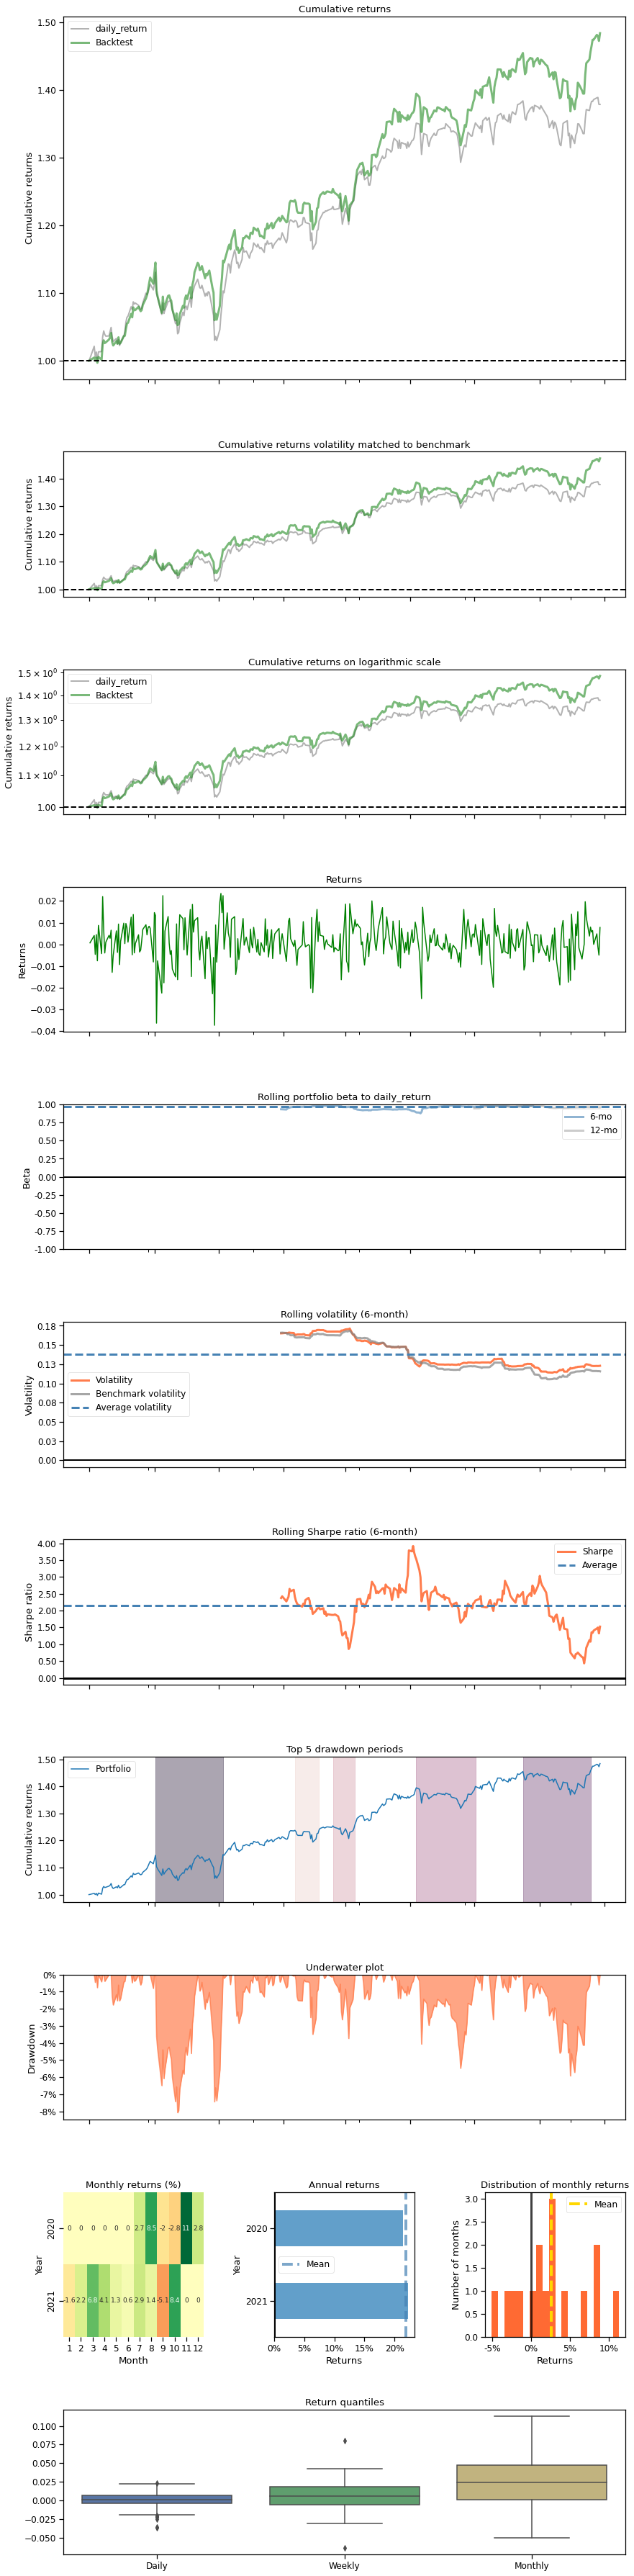

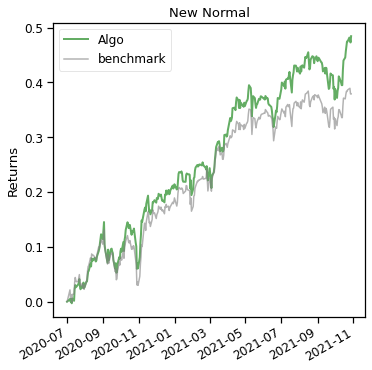

In [102]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])